In [1]:
from actiDep.data.loader import Subject, Actidep
import pandas as pd

db_root= '/home/ndecaux/NAS_EMPENN/share/projects/actidep/bids'

ds = Actidep(db_root)

one_cluster_csv = ds.get_global(datatype='metric',pipeline='hcp_association_50pts',suffix='mean')
multi_cluster_csv = ds.get_global(datatype='metric',pipeline='hcp_association_multiclusters_frechetlong_50pts',suffix='mean')


print(len(one_cluster_csv))
print(len(multi_cluster_csv))

df_one = pd.concat([f.df for f in one_cluster_csv])
df_multi = pd.concat([f.df for f in multi_cluster_csv])



4260
4260


In [2]:
df = df_one.merge(df_multi, on=['subject','bundle'], suffixes=('_one','_multi'))
participant_info = pd.read_excel('/home/ndecaux/NAS_EMPENN/share/projects/actidep/bids/participants_full_info.xlsx')
df[df['path_multi'].isna()]
#Merge with participant info
df = df.merge(participant_info, left_on='subject', right_on='participant_id')
print(len(df))
df=df[df['group']=='hc']
print(len(df))

0
0


In [3]:
big_df_one= []
for f in one_cluster_csv:
    _df = pd.read_csv(f.path)
    _df['subject'] = f.subject
    _df['bundle'] = f.bundle
    _df['clustering'] = 'single'
    big_df_one.append(_df)

for f in multi_cluster_csv:
    _df = pd.read_csv(f.path)
    _df['subject'] = f.subject
    _df['bundle'] = f.bundle
    _df['clustering'] = 'multi'
    big_df_one.append(_df)
big_df_one = pd.concat(big_df_one)

big_df_one
big_one_copy = big_df_one.copy()


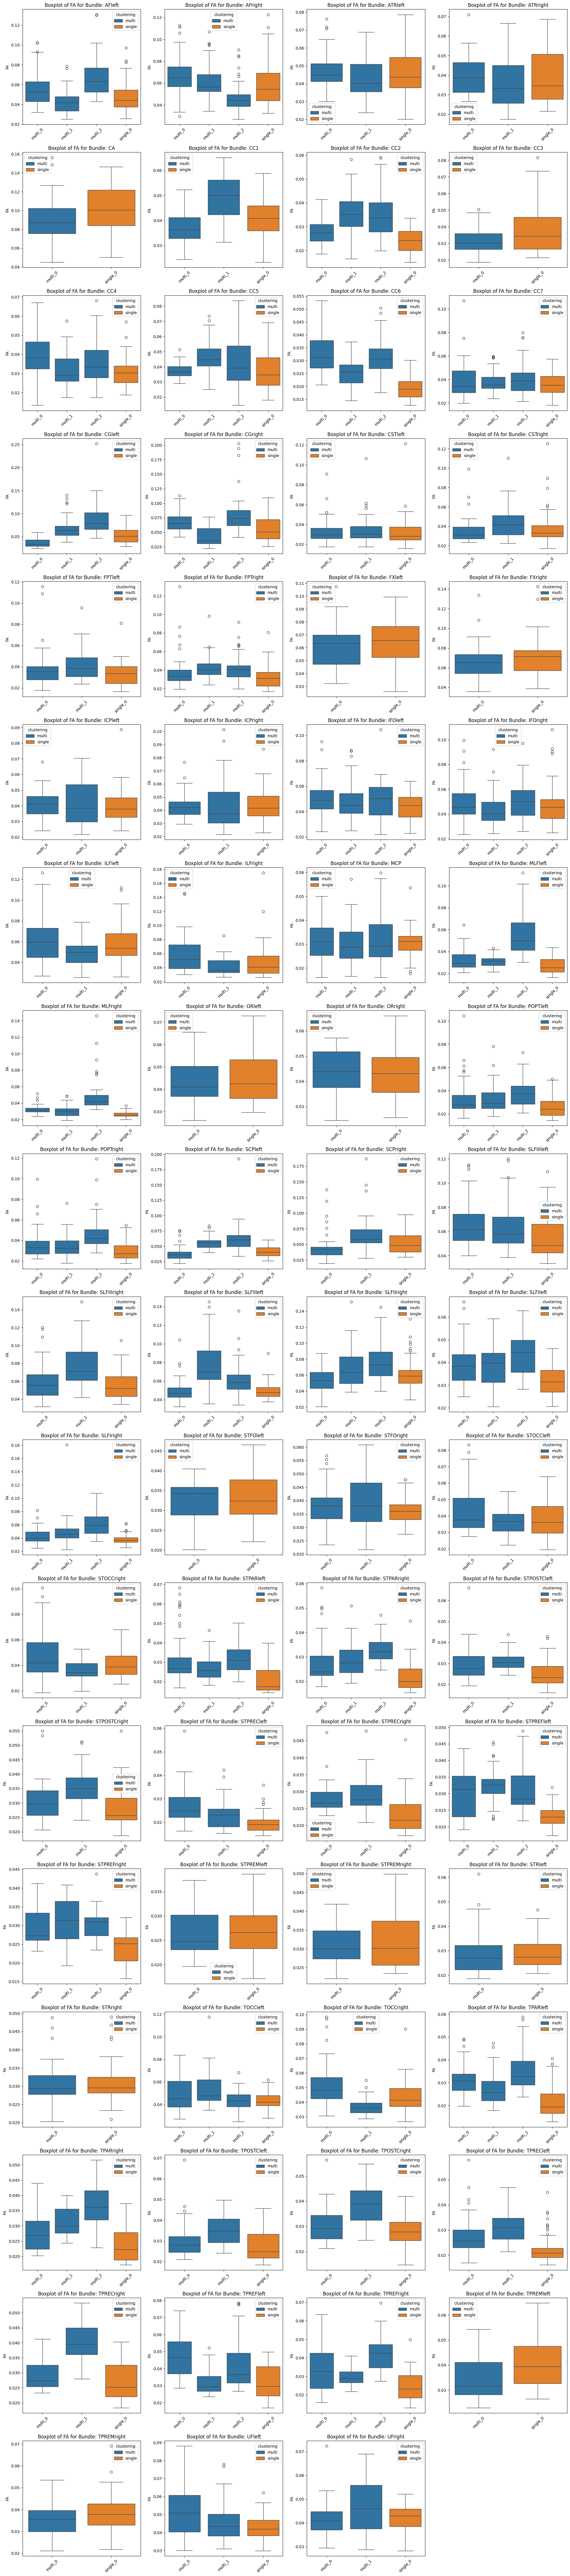

In [4]:
import os
participant_info['subject'] = participant_info['participant_id'].str.split('-').str[1]
big_df_one = big_one_copy.merge(participant_info, on='subject')
big_df_one = big_df_one[big_df_one['group']=='hc']
out_dir='/home/ndecaux/Images/EXP/compare_clustering'
os.makedirs(out_dir, exist_ok=True)
#Calcule l'écart-type moyen par point_id pour chaque bundle et centroid_id
big_df_one_std = big_df_one.groupby(['bundle','clustering','point_id','centroid_id'])[['FA','IFW']].std().reset_index()
big_df_one_std['centroid']= big_df_one_std['clustering'] + '_' + big_df_one_std['centroid_id'].astype(str)
# big_df_one_std.groupby(['bundle','clustering']).mean().reset_index()
#Display boxplot of FA and IFW for each bundle, centroid_id and clustering
import seaborn as sns
import matplotlib.pyplot as plt

# Create subplots for each bundle
unique_bundles = big_df_one_std['bundle'].unique()
n_bundles = len(unique_bundles)
#Get 4 columns and as many rows as needed
n_cols = 4
n_rows = (n_bundles + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))

for ax, bundle in zip(axes.flatten(), unique_bundles):
    sns.boxplot(data=big_df_one_std[big_df_one_std['bundle'] == bundle], 
                x='centroid', y='FA', hue='clustering', ax=ax)
    ax.set_title(f'Boxplot of FA for Bundle: {bundle}')
    ax.set_xlabel('')
    ax.set_ylabel('FA')
    ax.tick_params(axis='x', rotation=45)

# Hide any unused subplots
for ax in axes.flatten()[len(unique_bundles):]:
    ax.set_visible(False)

plt.tight_layout()
plt.savefig(f'{out_dir}/boxplot_FA_by_bundle_and_clustering.pdf')



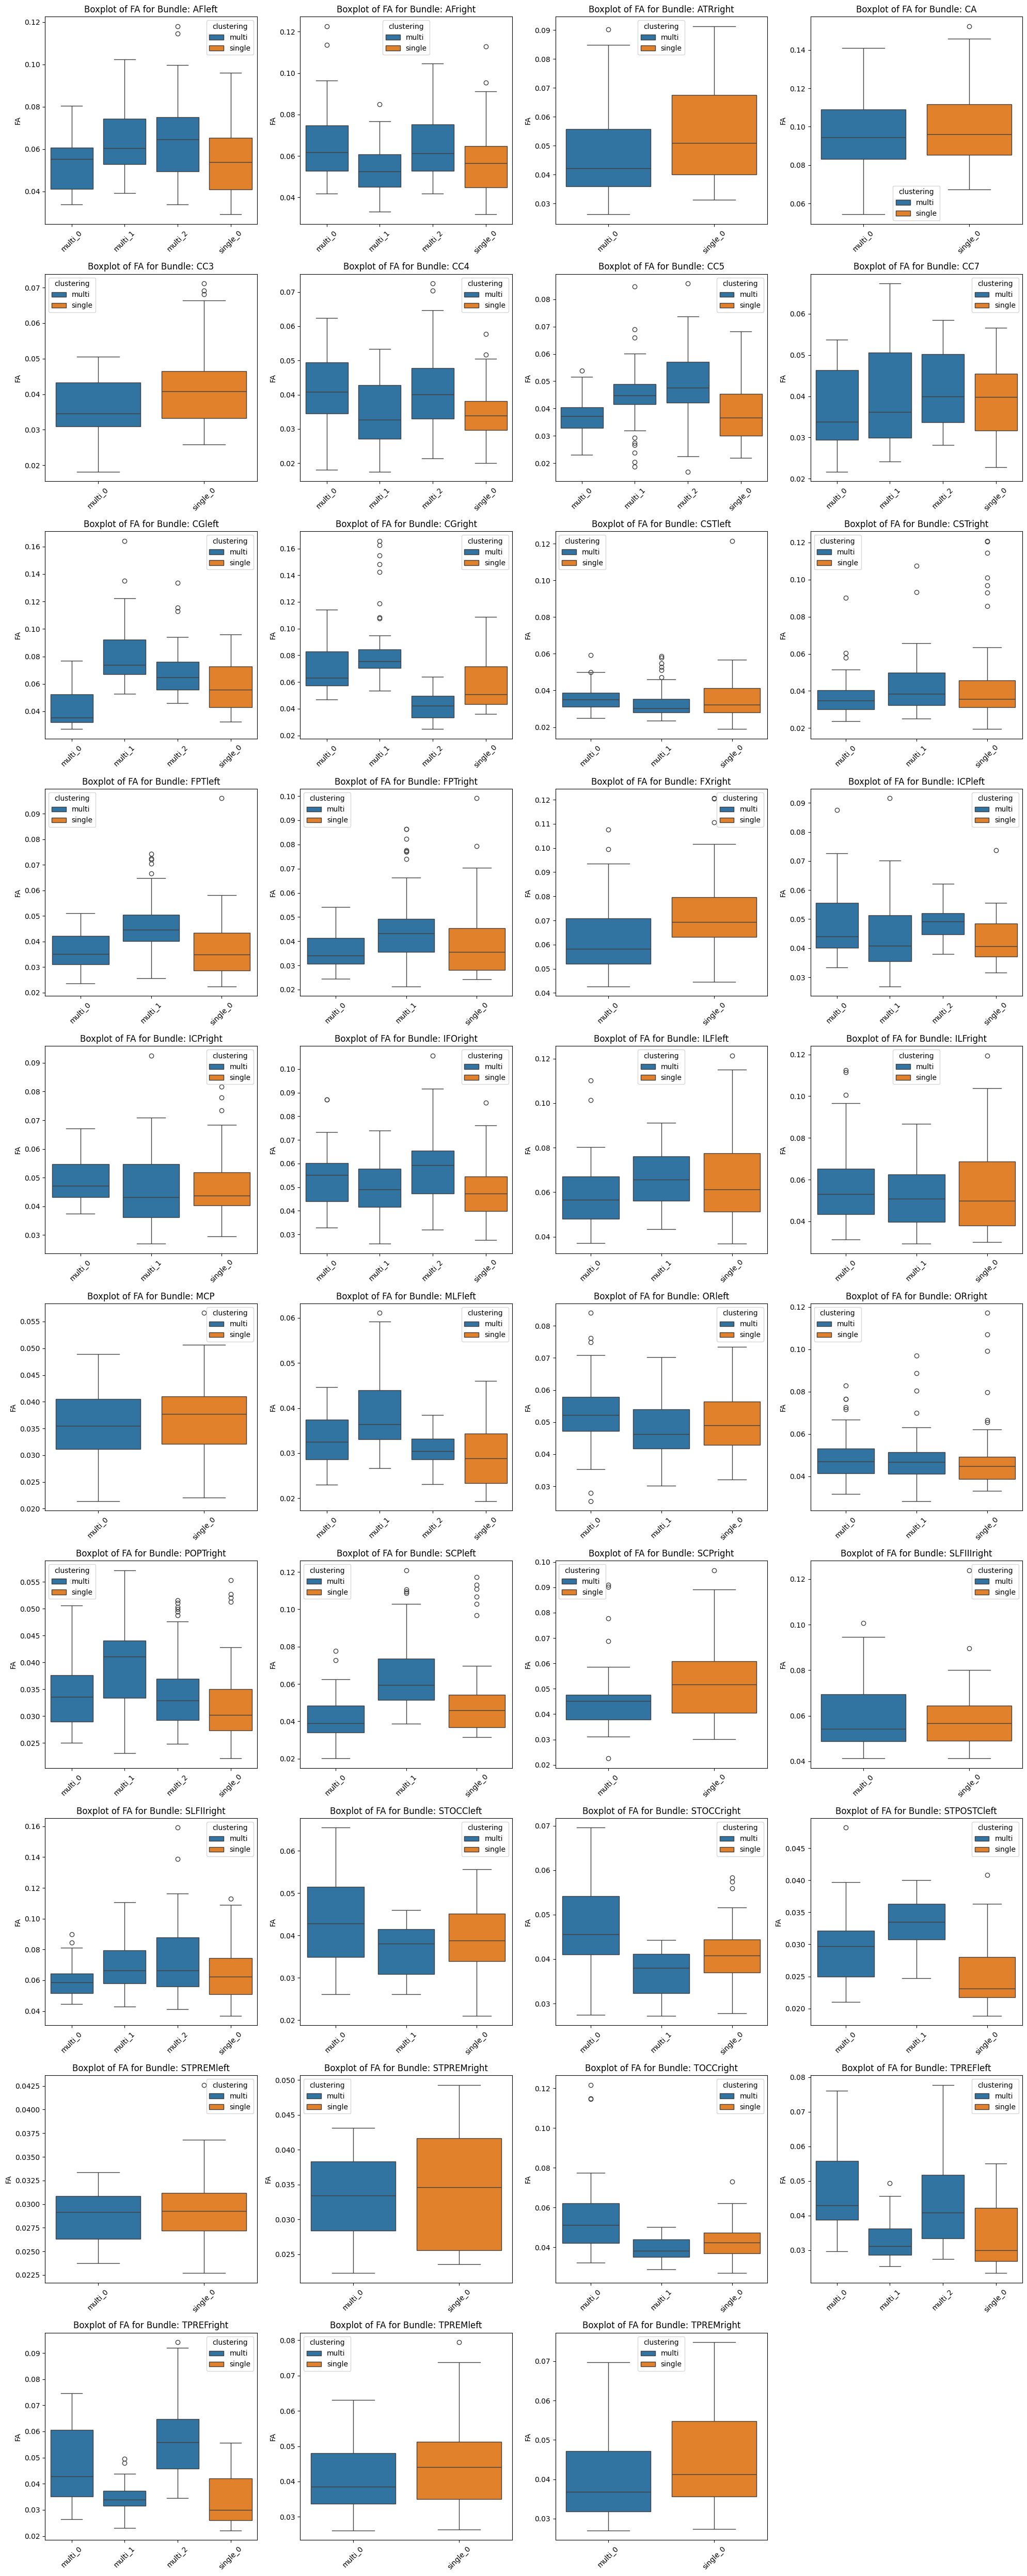

In [78]:
#Plot the same thing, but only for bundle where on centroid max of clustering=='multi' is lower than the max of clustering=='single'
#Get the max of FA for each bundle and clustering
max_fa = big_df_one_std.groupby(['bundle','centroid'])['FA'].max().unstack()
#Get the bundle where the max of clustering=='multi' is lower than the max of clustering=='single'
filter = (max_fa['multi_0'] < max_fa['single_0']) | (max_fa['multi_1'] < max_fa['single_0']) | (max_fa['multi_2'] < max_fa['single_0'])
bundles_to_plot = max_fa[filter].index.tolist()
# print(bundles_to_plot)

n_bundles = len(bundles_to_plot)
#Get 4 columns and as many rows as needed
n_cols = 4
n_rows = (n_bundles + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))

for ax, bundle in zip(axes.flatten(), bundles_to_plot):
    sns.boxplot(data=big_df_one_std[big_df_one_std['bundle'] == bundle], 
                x='centroid', y='FA', hue='clustering', ax=ax)
    ax.set_title(f'Boxplot of FA for Bundle: {bundle}')
    ax.set_xlabel('')
    ax.set_ylabel('FA')
    ax.tick_params(axis='x', rotation=45)

# Hide any unused subplots
for ax in axes.flatten()[len(bundles_to_plot):]:
    ax.set_visible(False)

plt.tight_layout()
plt.savefig(f'{out_dir}/boxplot_FA_by_bundle_and_clustering_bestof.pdf')


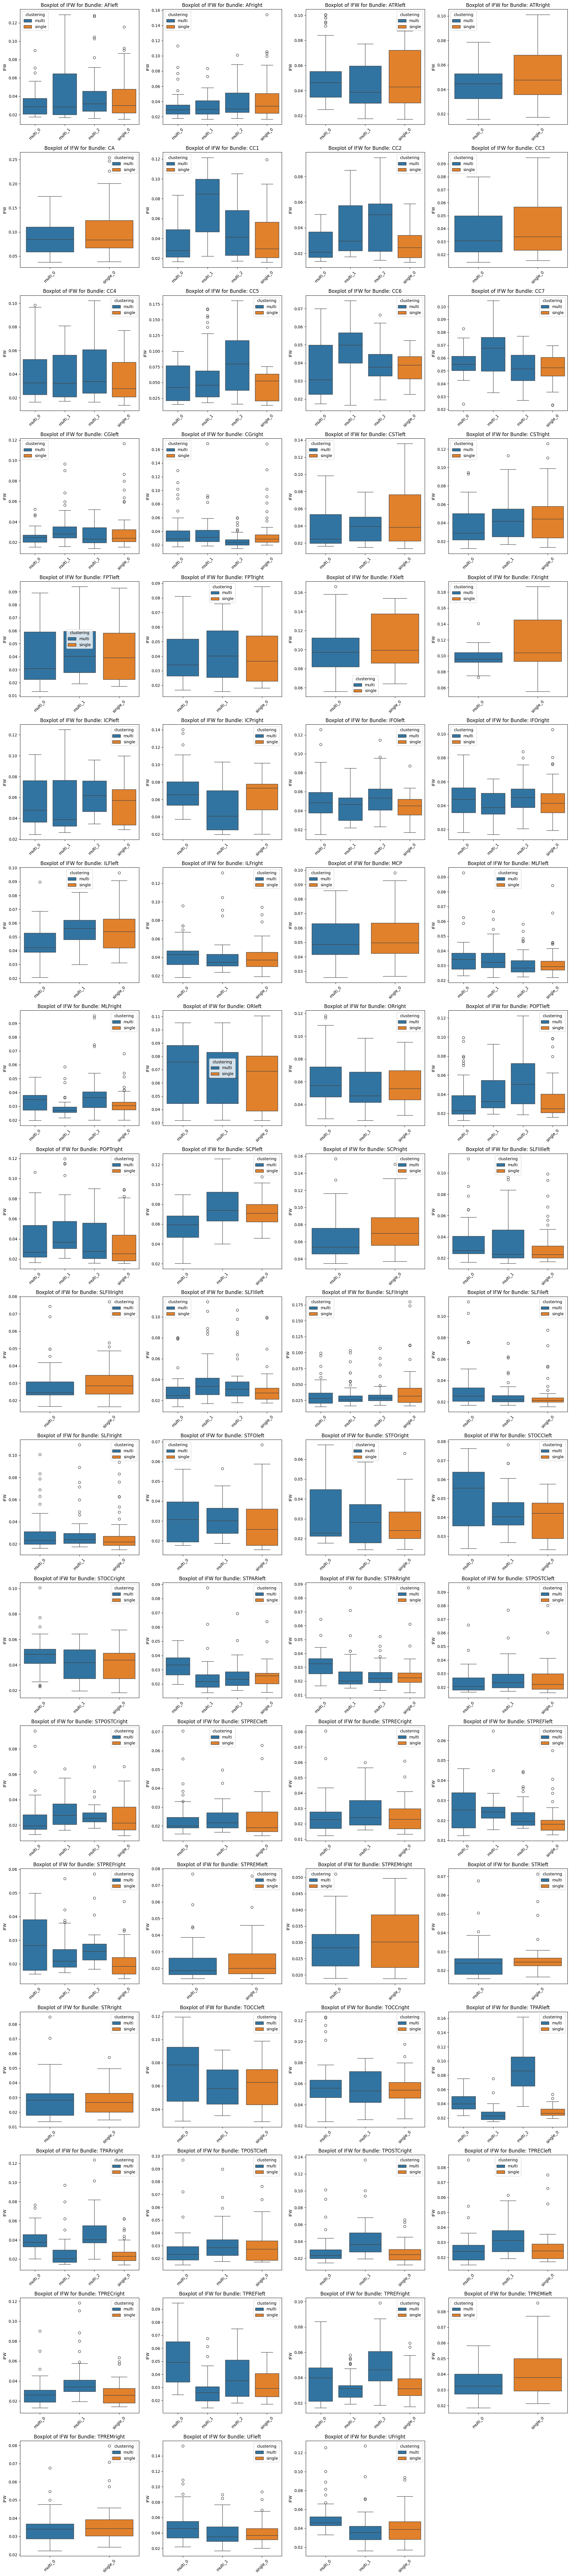

In [102]:
# Create subplots for each bundle
unique_bundles = big_df_one_std['bundle'].unique()
n_bundles = len(unique_bundles)
#Get 4 columns and as many rows as needed
n_cols = 4
n_rows = (n_bundles + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))

for ax, bundle in zip(axes.flatten(), unique_bundles):
    sns.boxplot(data=big_df_one_std[big_df_one_std['bundle'] == bundle], 
                x='centroid', y='IFW', hue='clustering', ax=ax)
    ax.set_title(f'Boxplot of IFW for Bundle: {bundle}')
    ax.set_xlabel('')
    ax.set_ylabel('IFW')
    ax.tick_params(axis='x', rotation=45)

# Hide any unused subplots
for ax in axes.flatten()[len(unique_bundles):]:
    ax.set_visible(False)

plt.tight_layout()
plt.savefig(f'{out_dir}/boxplot_IFW_by_bundle_and_clustering.pdf')

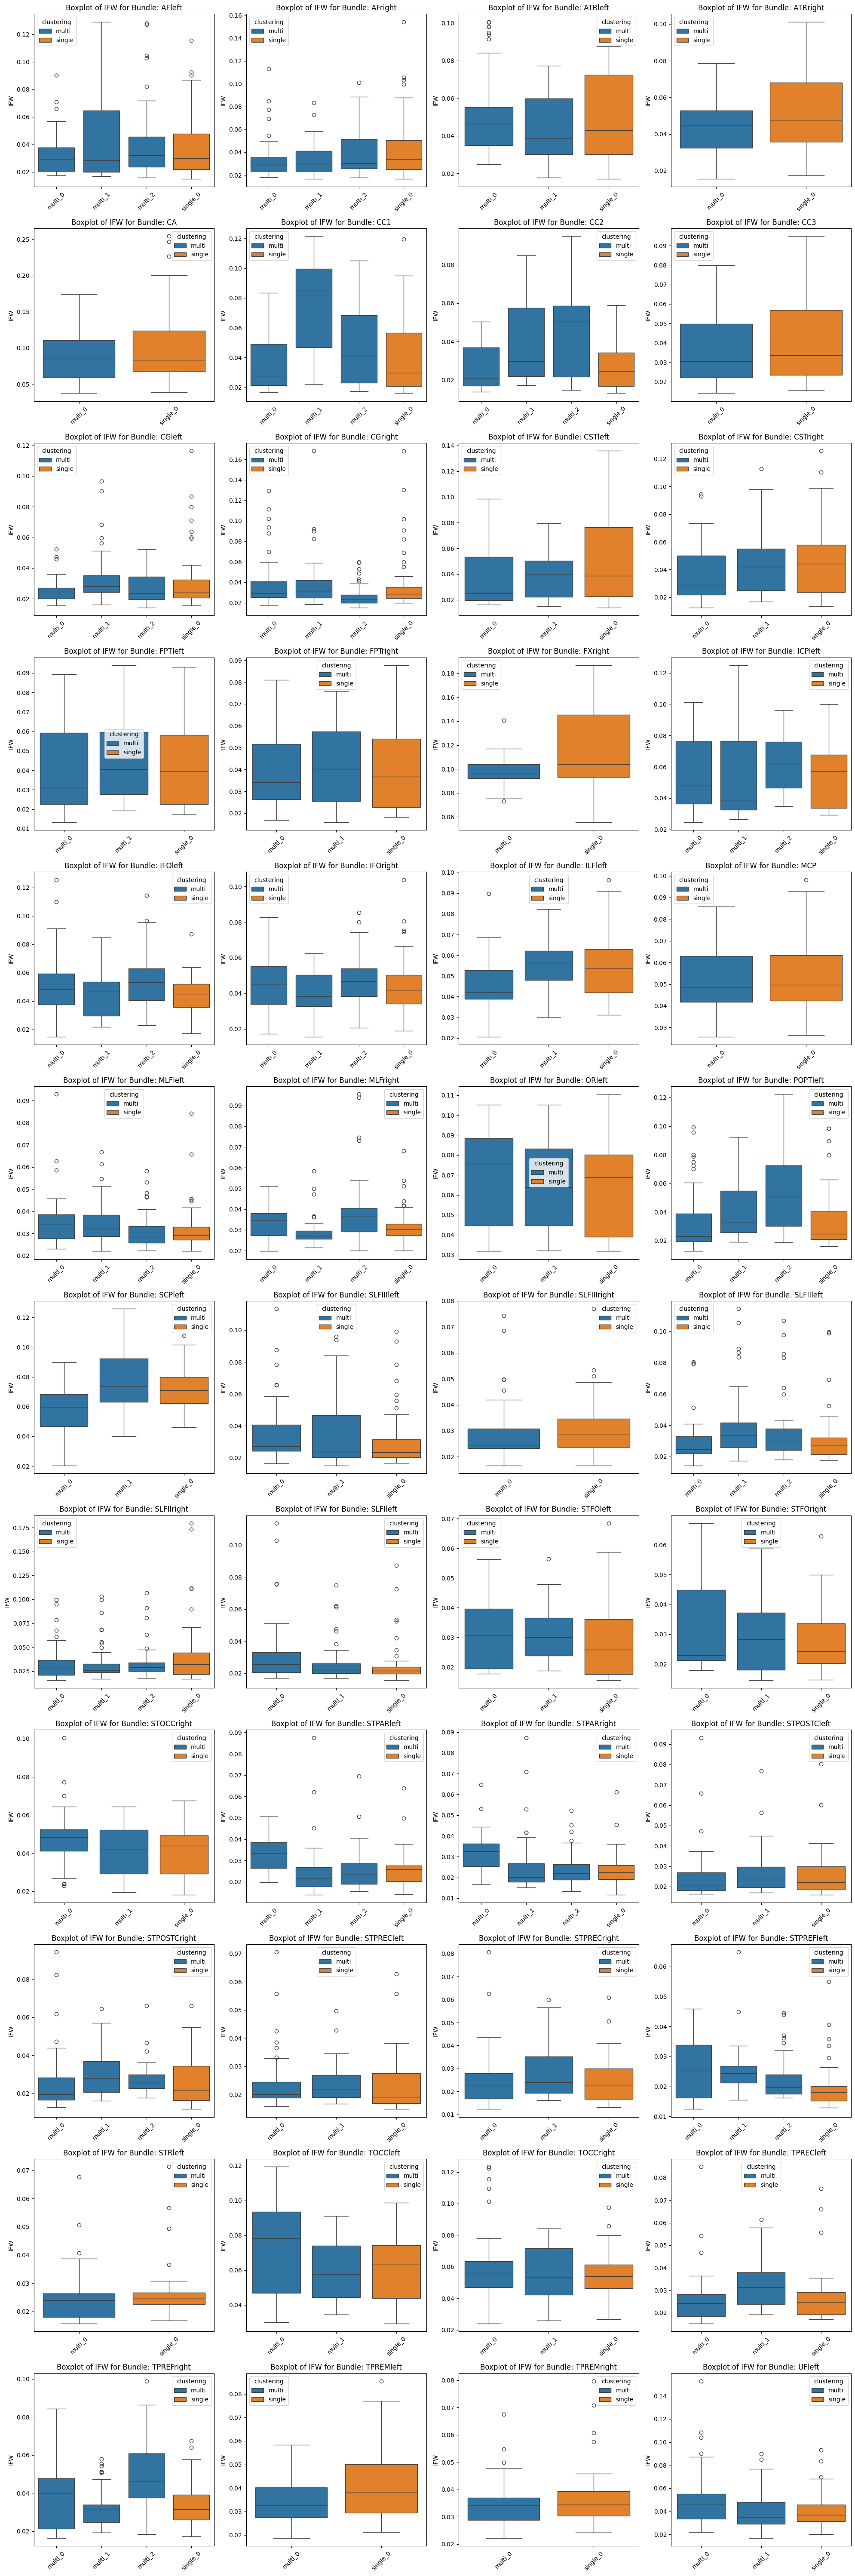

In [103]:
#Plot the same thing, but only for bundle where on centroid max of clustering=='multi' is lower than the max of clustering=='single'
#Get the max of IFW for each bundle and clustering
max_fa = big_df_one_std.groupby(['bundle','centroid'])['IFW'].max().unstack()
#Get the bundle where the max of clustering=='multi' is lower than the max of clustering=='single'
filter = (max_fa['multi_0'] < max_fa['single_0']) | (max_fa['multi_1'] < max_fa['single_0']) | (max_fa['multi_2'] < max_fa['single_0'])
bundles_to_plot = max_fa[filter].index.tolist()
# print(bundles_to_plot)

n_bundles = len(bundles_to_plot)
#Get 4 columns and as many rows as needed
n_cols = 4
n_rows = (n_bundles + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))

for ax, bundle in zip(axes.flatten(), bundles_to_plot):
    sns.boxplot(data=big_df_one_std[big_df_one_std['bundle'] == bundle], 
                x='centroid', y='IFW', hue='clustering', ax=ax)
    ax.set_title(f'Boxplot of IFW for Bundle: {bundle}')
    ax.set_xlabel('')
    ax.set_ylabel('IFW')
    ax.tick_params(axis='x', rotation=45)

# Hide any unused subplots
for ax in axes.flatten()[len(bundles_to_plot):]:
    ax.set_visible(False)

plt.tight_layout()
plt.savefig(f'{out_dir}/boxplot_IFW_by_bundle_and_clustering_bestof.pdf')


In [81]:
global_single = ds.get_global(datatype='metric',pipeline='hcp_association_50pts',suffix='stats',desc='global')
global_multi = ds.get_global(datatype='metric',pipeline='hcp_association_50pts_multiclusters',suffix='stats',desc='global')

df_global_single = pd.concat([f.df for f in global_single])
df_global_multi = pd.concat([f.df for f in global_multi])

df_global_single

,subject,datatype,pipeline,derivative,extension,suffix,desc,model,space,bundle,path,age,label,algo
0,01034,metric,hcp_association_50pts,True,.csv,stats,global,MCM,HCP,AFleft,/home/ndecaux/NAS_EMPENN/share/projects/actide...,1.759816e+09,NaN,NaN
0,01034,metric,hcp_association_50pts,True,.csv,stats,global,MCM,HCP,AFright,/home/ndecaux/NAS_EMPENN/share/projects/actide...,1.759816e+09,NaN,NaN
0,01034,metric,hcp_association_50pts,True,.csv,stats,global,MCM,HCP,ATRleft,/home/ndecaux/NAS_EMPENN/share/projects/actide...,1.759816e+09,NaN,NaN
0,01034,metric,hcp_association_50pts,True,.csv,stats,global,MCM,HCP,ATRright,/home/ndecaux/NAS_EMPENN/share/projects/actide...,1.759816e+09,NaN,NaN
0,01034,metric,hcp_association_50pts,True,.csv,stats,global,MCM,HCP,CA,/home/ndecaux/NAS_EMPENN/share/projects/actide...,1.759816e+09,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,03025,metric,hcp_association_50pts,True,.csv,stats,global,MCM,HCP,TPREFright,/home/ndecaux/NAS_EMPENN/share/projects/actide...,1.759819e+09,brain,ifod2
0,03025,metric,hcp_association_50pts,True,.csv,stats,global,MCM,HCP,TPREMleft,/home/ndecaux/NAS_EMPENN/share/projects/actide...,1.759819e+09,brain,ifod2
0,03025,metric,hcp_association_50pts,True,.csv,stats,global,MCM,HCP,TPREMright,/home/ndecaux/NAS_EMPENN/share/projects/actide...,1.759819e+09,brain,ifod2
0,03025,metric,hcp_association_50pts,True,.csv,stats,global,MCM,HCP,UFleft,/home/ndecaux/NAS_EMPENN/share/projects/actide...,1.759819e+09,brain,ifod2
